In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---------------------

Take mean image as input rather than mean output 

# Retrieving and Preprocess Data

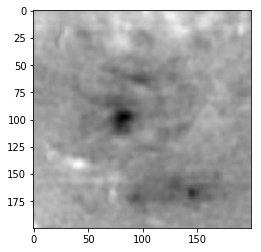

In [2]:
re_list = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
#re_list = np.load('test_npy/7-12-17-preprocessed.npy')
IMG_SIZE = re_list.shape[1]

#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(200, 200, 1) float32


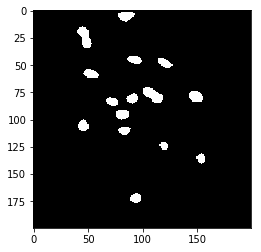

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (200, 200))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

----------------------------------------------------------


# Model

In [4]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block

l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', kernel_regularizer = True, batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu', kernel_regularizer = True,
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        

## Build Model

In [5]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 regularizer is activate!


-----------------------------------------------------------------

In [6]:
# dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(2).batch(1)


# def stack_fn(inp, stack, i):
#     print(i)
#     conv_img = model(inp) #value (0,1) because of sigmoid
#     stack+= tf.squeeze(conv_img)
#     #print('Mean is None!')
#     return stack

# def train(inp, stack, mean_roi, i):
#     print(i)
#     conv_img = model(inp) #value (0,1) because of sigmoid
#     stack+= tf.squeeze(conv_img)
#     print('Mean!')
#     mean_img = stack/(i+1)
#     mean_img = tf.expand_dims(mean_img, -1)
    
#     loss = utils.MSE_image(mean_roi, mean_img, 200)    
#     return loss, mean_img

# # one epochs is one training of one data session
# epochs = 0
# while epochs <2:
#     print("Epochs!:",epochs+1)
#     #initialize stack in every new epochs or new data session
#     stack = tf.zeros((200, 200))
#     #print(stack)
#     for i, (img) in enumerate(dst):
#         if i < 604:
#             stack =stack_fn(img, stack, i)
#             #print(stack)
#             continue
#         if i == 604:
#             loss, mean_img = train(img, stack, mean_roi, i)
#     print(loss)
#     print(mean_img)
#     epochs+=1

In [7]:
# #sanity check
# utils.MSE_image(mean_roi, mean_img, 200)

In [8]:
# plt.imshow(np.squeeze(mean_img))

--------------------------------------------------------

## Train Model

In [9]:
# from utils_model import img_mean, min_max_norm
# #loss function
# loss_fn = tf.losses.MeanSquaredError()
# #loss_fn = lambda x,y: dice_coef_loss(x,y)
# #loss_fn = lambda x,y: jaccard_distance_loss(x,y)

# #optimizer 
# lr = 1e-3
# opt = tf.optimizers.Adam(lr)
# dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(100).batch(1)


# def stack_fn(inp, stack, i):
#     '''
#     Idea of this function is to stacked (#frames -1)
#     images before the train step
#     '''
#     if not i%100:
#         print("Stacked up till step: {:4d}". format(i))
    
#     conv_img = model(inp) #value (0,1) because of sigmoid
#     stack+= tf.squeeze(conv_img)
#     return stack
    
# @tf.function
# def train(inp, stack,mean_roi, i):
#     with tf.GradientTape() as tape:

#         conv_img = model(inp) #value (0,1) because of sigmoid
#         stack+= tf.squeeze(conv_img)
#         mean_img = stack/(i+1)
#         mean_img = tf.expand_dims(mean_img, -1)
            
#         xent = loss_fn(mean_roi, mean_img)

#     grads = tape.gradient(xent, model.trainable_variables)
#     opt.apply_gradients(zip(grads, model.trainable_variables))
    
#     return xent, mean_img

# ori_list = [] #original image list
# de_list = [] #mean image fromt the network list
# loss_list = [] #loss list

# epochs = 0

# while epochs < 100:
#     print('Epochs:', epochs+1)
#     # One epochs is one run through one session!
#     #initialize stack in every new epochs or new data session
#     stack = tf.zeros((200, 200))
#     for step, (img_batch) in enumerate(dst):
#         if step < 604:
#             stack =stack_fn(img_batch, stack, step)
#             continue
#         if step == 604:
#             xent, mean_img = train(img_batch, stack, mean_roi,step)
# #         ori_list.append(img_batch)
#     de_list.append(mean_img)
#     loss_list.append(xent)

#     print("Trained session{:2d}, Loss: {}".format(epochs +1, xent.numpy()))
#     print()
#     epochs+=1

In [10]:
# from utils_model import img_mean, min_max_norm
# #loss function
# loss_fn = tf.losses.MeanSquaredError()
# #loss_fn = lambda x,y: dice_coef_loss(x,y)
# #loss_fn = lambda x,y: jaccard_distance_loss(x,y)

# #optimizer 
# lr = 1e-3
# opt = tf.optimizers.Adam(lr)
# dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(100).batch(1)

    
# @tf.function
# def train(inp, stack,mean_roi, i):
#     with tf.GradientTape() as tape:
#         if i<605:
#             if not i%100:
#                 print("Stacked up till step: {:4d}". format(i))
        
#             conv_img = model(inp) #value (0,1) because of sigmoid
#             stack+= tf.squeeze(conv_img)
#             xent = 0
#             mean_img = 0
#         if i == 605-1:
#             mean_img = stack/605
#             mean_img = tf.expand_dims(mean_img, -1)
#             xent = loss_fn(mean_roi, mean_img)

#             grads = tape.gradient(xent, model.trainable_variables)
#             opt.apply_gradients(zip(grads, model.trainable_variables))
    
#         return xent, mean_img, stack

# ori_list = [] #original image list
# de_list = [] #mean image fromt the network list
# loss_list = [] #loss list

# epochs = 0

# while epochs < 10:
#     print('Epochs:', epochs+1)
#     # One epochs is one run through one session!
#     #initialize stack in every new epochs or new data session
#     stack = tf.zeros((200, 200))
#     for step, (img_batch) in enumerate(dst):
#         if step < 605:
#             xent, mean_img, stack = train(img_batch, stack, mean_roi,step)
#             continue
# #         ori_list.append(img_batch)
#     de_list.append(mean_img)
#     loss_list.append(xent)

#     print("Trained session{:2d}, Loss: {}".format(epochs +1, xent.numpy()))
#     print()
#     epochs+=1

In [11]:
# from utils_model import img_mean, min_max_norm
# #loss function
# loss_fn = tf.losses.MeanSquaredError()
# #loss_fn = lambda x,y: dice_coef_loss(x,y)
# #loss_fn = lambda x,y: jaccard_distance_loss(x,y)

# #optimizer 
# lr = 1e-3
# opt = tf.optimizers.Adam(lr)
# dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(100).batch(1)

    
# @tf.function
# def train(inp, stack,mean_roi, i):
#     with tf.GradientTape() as tape:
#         if not i%100:
#             print("Stacked up till step: {:4d}". format(i))

#         conv_img = model(inp) #value (0,1) because of sigmoid
#         stack+=tf.squeeze(conv_img)
#         mean_img = tf.zeros((200,200,1))
        
#         if tf.math.equal(i,605-1):
#             mean_img = stack/605
#             mean_img = tf.expand_dims(mean_img, -1)
            
#         xent = loss_fn(mean_roi, mean_img)
#         grads = tape.gradient(xent, model.trainable_variables)
#         opt.apply_gradients(zip(grads, model.trainable_variables))
    
#         return xent, mean_img, stack

# ori_list = [] #original image list
# de_list = [] #mean image fromt the network list
# loss_list = [] #loss list

# epochs = 0

# while epochs < 10:
#     print('Epochs:', epochs+1)
#     # One epochs is one run through one session!
#     #initialize stack in every new epochs or new data session
#     stack = tf.zeros((200, 200))
#     for step, (img_batch) in enumerate(dst):
#         if step < 605:
#             xent, mean_img, stack = train(img_batch, stack, mean_roi,step)
#             continue
# #         ori_list.append(img_batch)
#     de_list.append(mean_img)
#     loss_list.append(xent)

#     print("Trained session{:2d}, Loss: {}".format(epochs +1, xent.numpy()))
#     print()
#     epochs+=1

In [12]:
from utils_model import img_mean, min_max_norm
#loss function
loss_fn = tf.losses.MeanSquaredError()
#loss_fn = lambda x,y: dice_coef_loss(x,y)
#loss_fn = lambda x,y: jaccard_distance_loss(x,y)

#optimizer 
lr = 1e-3
opt = tf.optimizers.Adam(lr)
dst = tf.data.Dataset.from_tensor_slices(re_list).repeat(100).batch(1)

    
@tf.function
def train(inp, stack,mean_roi, i):
    with tf.GradientTape() as tape:
        xent = 0.0
        mean_img = tf.zeros((200, 200))
        if tf.math.less(i,605):
            conv_img = model(inp) #value (0,1) because of sigmoid
            stack+= tf.squeeze(conv_img)
        if tf.math.equal(i,605-1):
            mean_img = stack/605
            mean_img = tf.expand_dims(mean_img, -1)
            xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))

    return xent, mean_img, stack

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

epochs = 0

while epochs < 10:
    print('Epochs:', epochs+1)
    # One epochs is one run through one session!
    #initialize stack in every new epochs or new data session
    stack = tf.zeros((200, 200))
    for step, (img_batch) in enumerate(dst):
        if step < 605:
            xent, mean_img, stack = train(img_batch, stack, mean_roi,step)
            if not step%100:
                print("Stacking reach image no.",step)
            continue
#         ori_list.append(img_batch)
    de_list.append(mean_img)
    loss_list.append(xent)

    print("Trained session{:2d}, Loss: {}".format(epochs +1, xent.numpy()))
    print()
    epochs+=1

Epochs: 1
Stacking reach image no. 0
Stacking reach image no. 100
Stacking reach image no. 200
Stacking reach image no. 300
Stacking reach image no. 400
Stacking reach image no. 500
Stacking reach image no. 600
Trained session 1, Loss: 0.0427599735558033

Epochs: 2
Stacking reach image no. 0
Stacking reach image no. 100
Stacking reach image no. 200
Stacking reach image no. 300
Stacking reach image no. 400
Stacking reach image no. 500
Stacking reach image no. 600
Trained session 2, Loss: 0.03264988958835602

Epochs: 3
Stacking reach image no. 0
Stacking reach image no. 100
Stacking reach image no. 200
Stacking reach image no. 300
Stacking reach image no. 400
Stacking reach image no. 500
Stacking reach image no. 600
Trained session 3, Loss: 0.03264996036887169

Epochs: 4
Stacking reach image no. 0
Stacking reach image no. 100
Stacking reach image no. 200
Stacking reach image no. 300
Stacking reach image no. 400
Stacking reach image no. 500
Stacking reach image no. 600
Trained session 4, 

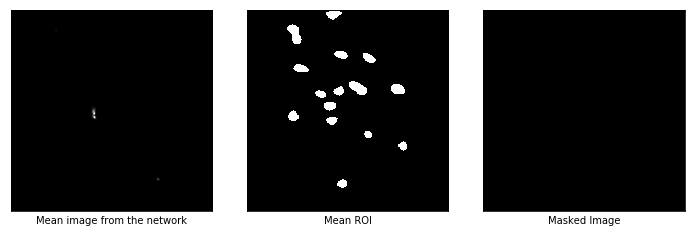

Loss: 0.03264996
Dice coefficient:  1.2159927307564275e-06



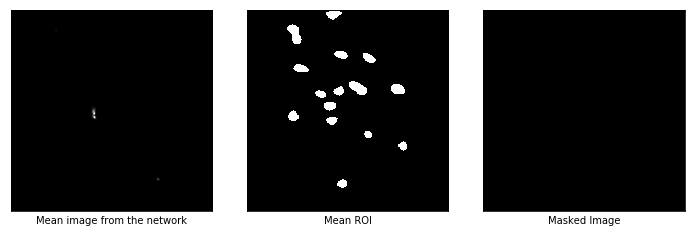

Loss: 0.03264996
Dice coefficient:  1.2159927307564275e-06



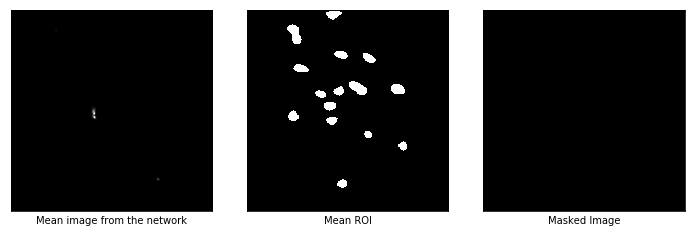

Loss: 0.03264996
Dice coefficient:  1.2159927307564275e-06



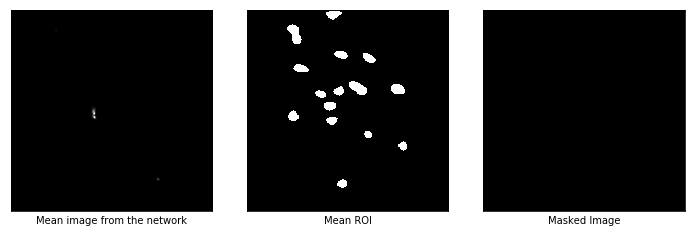

Loss: 0.03264996
Dice coefficient:  1.2159927307564275e-06



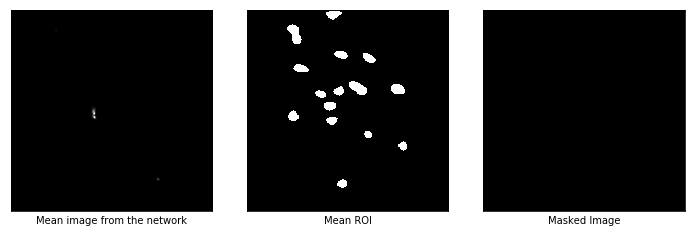

Loss: 0.03264996
Dice coefficient:  1.2159927307564275e-06


In [13]:
from utils import masked_img, dice_coef_py
from utils_vis import plot_comparison
#plot for mean image of last 5 steps w.r.t mean roi 
for i in range(5):
    mean_image = de_list[len(de_list) - 5 + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - 5 + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

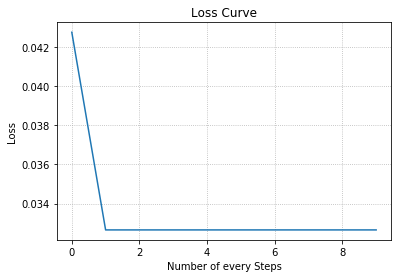

In [14]:
utils_vis.plot_loss(loss_list)